In [131]:


import _init_paths
from PIL import Image
import numpy as np
import cv2
import random
import copy

import torch
import torchvision.transforms as T
import torchvision.transforms.functional as TF
import torch.nn.functional as F

from dall_e  import map_pixels, unmap_pixels, load_model
from IPython.display import display, display_markdown
from vcl.models.trackers import *
from vcl.utils import *
from mmcv.runner import get_dist_info, init_dist, load_checkpoint

import matplotlib.pyplot as plt
%matplotlib inline


target_image_size = 256

output_dir = '/home/lr/project/vcl_output/vis_correspondence_ablations_global'

if os.path.exists(output_dir): os.makedirs(output_dir, exist_ok=True)

samples = []
with open('/home/lr/dataset/YouTube-VOS/2018/train/test_records.txt', 'r') as f:
    for line in f.readlines():
        name, frame_idx, pixel_idx = line.strip('\n').split()
        samples.append([name, int(frame_idx), int(pixel_idx)])
        
visualizer = Correspondence_Visualizer(mode='pair', show_mode='plt', radius=6, blend_color='jet')


def build_model(strides=(1,2,2,1), depth=18, pretrained=None, model_pre=None, pool_type='none'):
    # final model
    model = VanillaTracker(
        backbone=dict(type='ResNet', depth=depth, strides=strides, out_indices=(2, ), pool_type=pool_type, pretrained=model_pre),
        test_cfg=dict(),
        train_cfg=dict()
        )

    if pretrained is not None:
        params = torch.load(pretrained)
        state_dict = params['state_dict']
        state_dict = { k:v for k,v in state_dict.items() if k.find('backbone') != -1}
        model.load_state_dict(state_dict, strict=False)
        
    model_name = 'final'

    model = model.cuda()
    model.eval()
    return model
    

def main(x1, x2, model, model_name='final'):
    model.eval()
    enc1 = model.backbone(x1.cuda())
    enc2 = model.backbone(x2.cuda())
    plt = visualizer.visualize([frame1, frame2], [enc1, enc2], sample_idx, return_all=False)
    
    return plt
    

2022-05-06 20:37:52,542 - vcl - INFO - Loading /home/lr/models/ssl/image_based/detco_200ep_AA.pth as torchvision


load checkpoint from local path: /home/lr/models/ssl/image_based/detco_200ep_AA.pth
sample frames from /home/lr/dataset/YouTube-VOS/2018/train/JPEGImages/2dcc417f82/00000.jpg 68 10


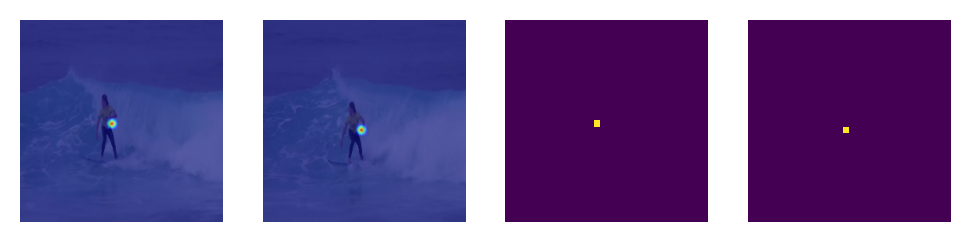

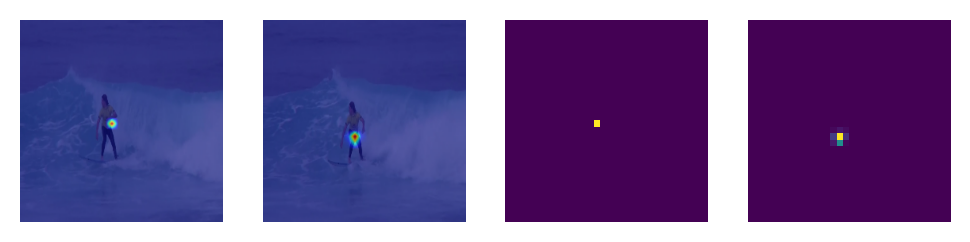

In [132]:
## sample frame
import os.path as osp
import glob

vname = None

# model1 = build_model(model_pre='/home/lr/models/ssl/image_based/moco_v2_res18_ep200_lab.pth')
model = build_model(strides=(1,2,1,1), depth=50, model_pre='/home/lr/models/ssl/image_based/detco_200ep_AA.pth', pool_type='max')
# model3 = build_model(pretrained='/home/lr/expdir/VCL/group_vqvae_tracker/mast_d4_l2_base_5/epoch_1600.pth')
model2 = build_model(pretrained='/home/lr/expdir/VCL/group_vqvae_tracker/mast_d4_l2_pyramid_dis_16/epoch_3200.pth')
# model3 = build_model(model_pre=None)
model3 = build_model(depth=50, pretrained='/home/lr/expdir/VCL/group_vqvae_tracker/final_framework_v2_9/epoch_1600.pth')

model4 = build_model(depth=50, model_pre='/home/lr/models/vos/model_s012_final_yv_revised_keys.pth')

sample = {}

sample_video_idx = random.randint(0, 300)

sample['frames_path'] = sorted(glob.glob(osp.join('/home/lr/dataset/YouTube-VOS/2018/train/JPEGImages', samples[sample_video_idx][0], '*.jpg'))) if vname is None else sorted(glob.glob(osp.join('/home/lr/dataset/YouTube-VOS/2018/train/JPEGImages', vname, '*.jpg')))

frame_idx = samples[sample_video_idx][1]
sample_idx = samples[sample_video_idx][2]
video_name = sample['frames_path'][0].split('/')[-2]


frame1 = cv2.imread(sample['frames_path'][frame_idx])[:,:,::-1]

frame2 = cv2.imread(sample['frames_path'][min(frame_idx+1, len(sample['frames_path'])-1)])[:,:,::-1]
frame1 = cv2.resize(frame1, (256,256))
frame2 = cv2.resize(frame2, (256,256))

print('sample frames from {}'.format(sample['frames_path'][0]), sample_video_idx, frame_idx)

x1_rgb = preprocess_(frame1, mode='rgb')
x2_rgb = preprocess_(frame2, mode='rgb')

x1_lab = preprocess_(frame1, mode='lab')
x2_lab = preprocess_(frame2, mode='lab')

outs = []
model_names = ['moco_v2_lab_res18', 'detco', 'rec', 'temporal', 'final']


plt = main(x1_rgb, x2_rgb, model)
plt.show()

plt = main(x1_lab, x2_lab, model2)
plt.show()    

plt = main(x1_lab, x2_lab, model3)
plt.show()   

plt = main(x1_rgb, x2_rgb, model4)
plt.show()   